In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_07260.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_07290.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_009000.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_08490_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07530_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_01350_P.png')]

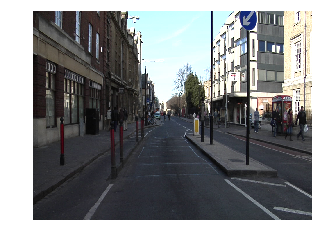

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

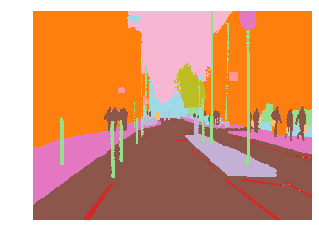

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:
size = src_size//2
bs=8

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(imagenet_stats))

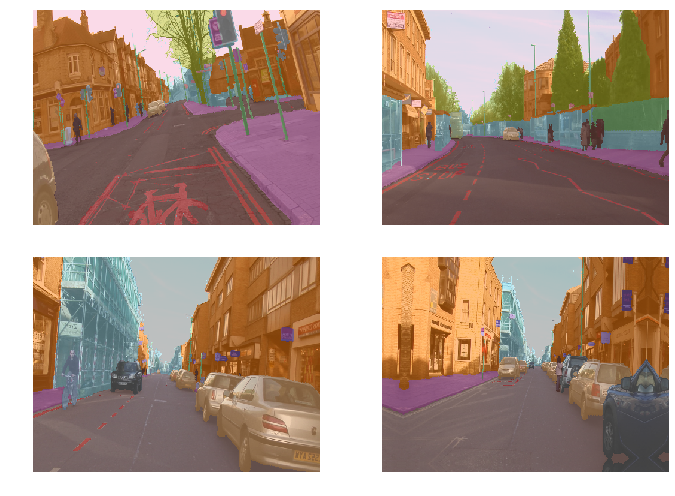

In [15]:
data.show_batch(2, figsize=(10,7))

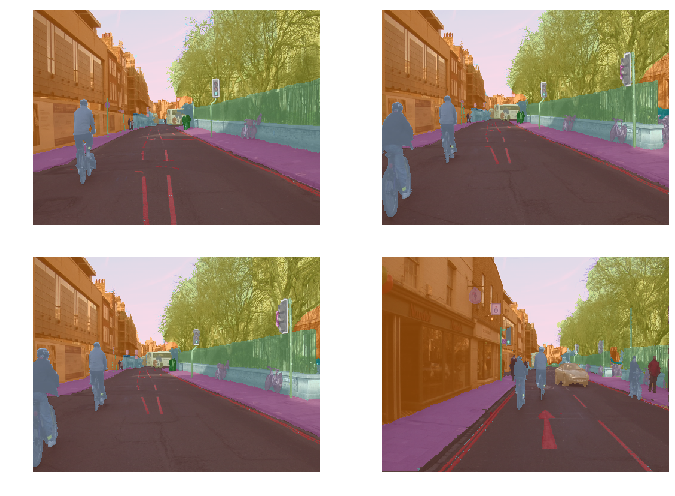

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
wd=1e-2

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 28.2MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


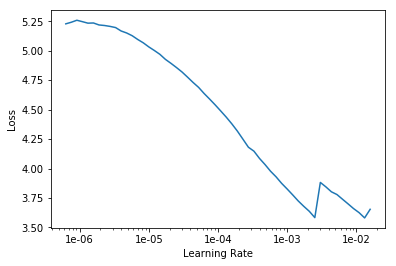

In [21]:
lr_find(learn)
learn.recorder.plot()

In [0]:
# lr = slice(1e-06,1e-03)

In [23]:
learn.fit_one_cycle(10, slice(1e-06,1e-03), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.803060,1.073710,0.771236,04:08
1,1.087449,0.752078,0.806617,04:07
2,0.782760,0.605871,0.838128,04:08
3,0.668749,0.539729,0.855129,04:07
4,0.615803,0.678264,0.813145,04:07
5,0.601410,0.529553,0.861671,04:07
6,0.552259,0.407751,0.888794,04:07
7,0.513472,0.392206,0.887702,04:06
8,0.490642,0.388322,0.891035,04:07
9,0.418501,0.320109,0.907113,04:06


In [0]:
path = "."

In [0]:
learn.save('stage-1')

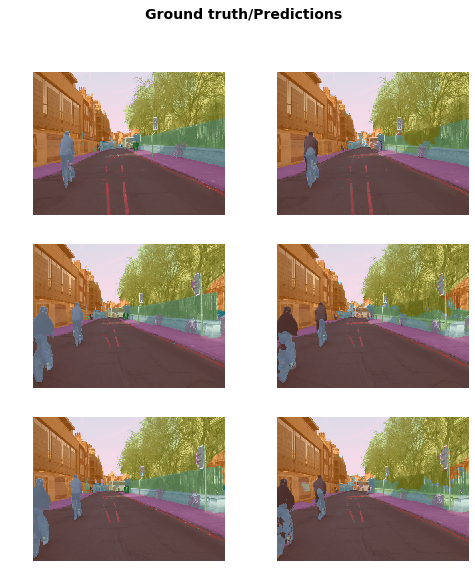

In [26]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


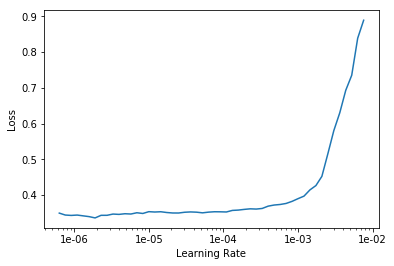

In [28]:
lr_find(learn)
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(12, slice(1e-5,1e-4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.358132,0.299096,0.916313,04:13
1,0.351286,0.293660,0.918050,04:12
2,0.344770,0.300461,0.914976,04:12
3,0.336116,0.285807,0.920836,04:13
4,0.332056,0.289924,0.918971,04:13
5,0.322505,0.278032,0.922197,04:13
6,0.315037,0.274874,0.923151,04:14
7,0.307002,0.273736,0.921848,04:13
8,0.300935,0.278873,0.920044,04:13
9,0.291706,0.275314,0.922470,04:13


In [0]:
learn.save('stage-2')